# YOLOv3 객체 검출
### 
### yolo 란 : you only look once
### 실시간 객체 검출 딥러닝 알고리즘
### 

In [116]:
import sys
import numpy as np
import cv2
from PIL import Image


# 모델 & 설정파일 
model = '/Users/jungjihoon/Desktop/darknet/yolov3.weights'
config = '/Users/jungjihoon/Desktop/darknet/cfg/yolov3.cfg'
class_labels = "/Users/jungjihoon/Desktop/darknet/data/coco.names"
confThreshold = 0.5
nmsThreshold = 0.4

# 테스트 이미지 파일
dog = "/Users/jungjihoon/Desktop/darknet/data/dog.jpg"
person = "/Users/jungjihoon/Desktop/darknet/data/person.jpg"
kite = '/Users/jungjihoon/Desktop/darknet/data/kite.jpg'
img_files = [person, dog, kite] #, person, kite]

# 네트워크 생성
net = cv2.dnn.readNet(model, config)

if net.empty():
    print('net open failed')
    sys.exit()
    
# 클래스 이름 불러오기
classes = []

with open(class_labels, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
    
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# 출력 레이어 이름 받아오기
layer_names = net.getLayerNames()
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
# output_layers = ['yolo_82', 'yolo_94', 'yolo_106']

# 실행
for f in img_files:
    img = cv2.imread(f)
    
    # 블롭 생성
    blob = cv2.dnn.blobFromImage(img, 1/255., (320, 320), swapRB=True)
    net.setInput(blob)
    outs = net.forward(output_layers)
    # outs[0].shape=(507, 85), 13*13*3=507
    # outs[1].shape=(2028, 85), 26*26*3=2028
    # outs[2].shape=(8112, 85), 52*52*3=8112
    
    h, w = img.shape[:2]
    
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        #print(out.shape)
        for detection in out:
            # detection: 4(bounding box) + 1(objectness_score) + 80(class confidence)
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confThreshold:
                # 바운딩 박스의 중심좌료
                cx = int(detection[0] * w)
                cy = int(detection[1] * h)
                # 바운딩 박스의 박스 크기
                bw = int(detection[2] * w)
                bh = int(detection[3] * h)
                # 바운딩 박스의 좌상단 좌표
                sx = int(cx - bw / 2)
                sy = int(cy - bh / 2)


                # confidence 값이 0.5보다 큰 바운딩 박스를 모두 boxes에 추가. 이때 confidence와 class_id도 함께 기록
                boxes.append([sx, sy, bw, bh])
                confidences.append(float(confidence))
                class_ids.append(int(class_id))

    # 비억제 최대
    # 40% 이상 겹치는 바운딩 박스에 대해 최대 confidence (>0.5) 바운딩 박스만 선별 indices.shape = (n,1) ==> 쉽게 말해 겹쳐져 있는 박스 중 confidence가 가장 큰 박스 선택
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    

    for i in indices:
        sx, sy, bw, bh = boxes[i]
        class_name = classes[class_ids[i]]
        label = f"{class_name} : {confidences[i]:.2f}"
        color = colors[class_ids[i]]
        cv2.rectangle(img, (sx, sy, bw, bh), color, 2)
        cv2.putText(img, label, (sx, sy-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

        
    t, _ = net.getPerfProfile()
    label = 'inference time : %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_TRIPLEX, 0.7, (0,0,255), 1, cv2.LINE_AA)

    globals()[f"img_{i}"] = Image.fromarray(img)


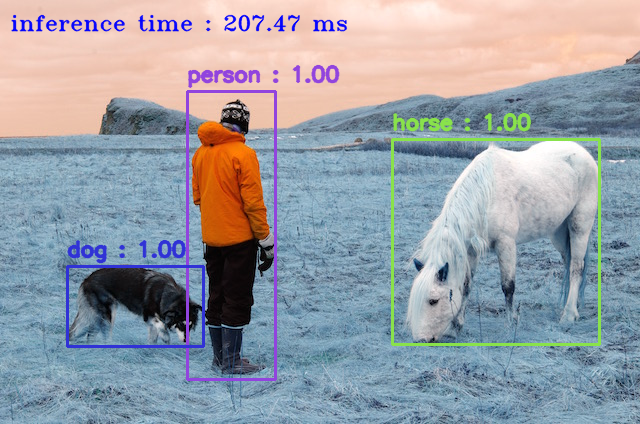

In [120]:
img_0

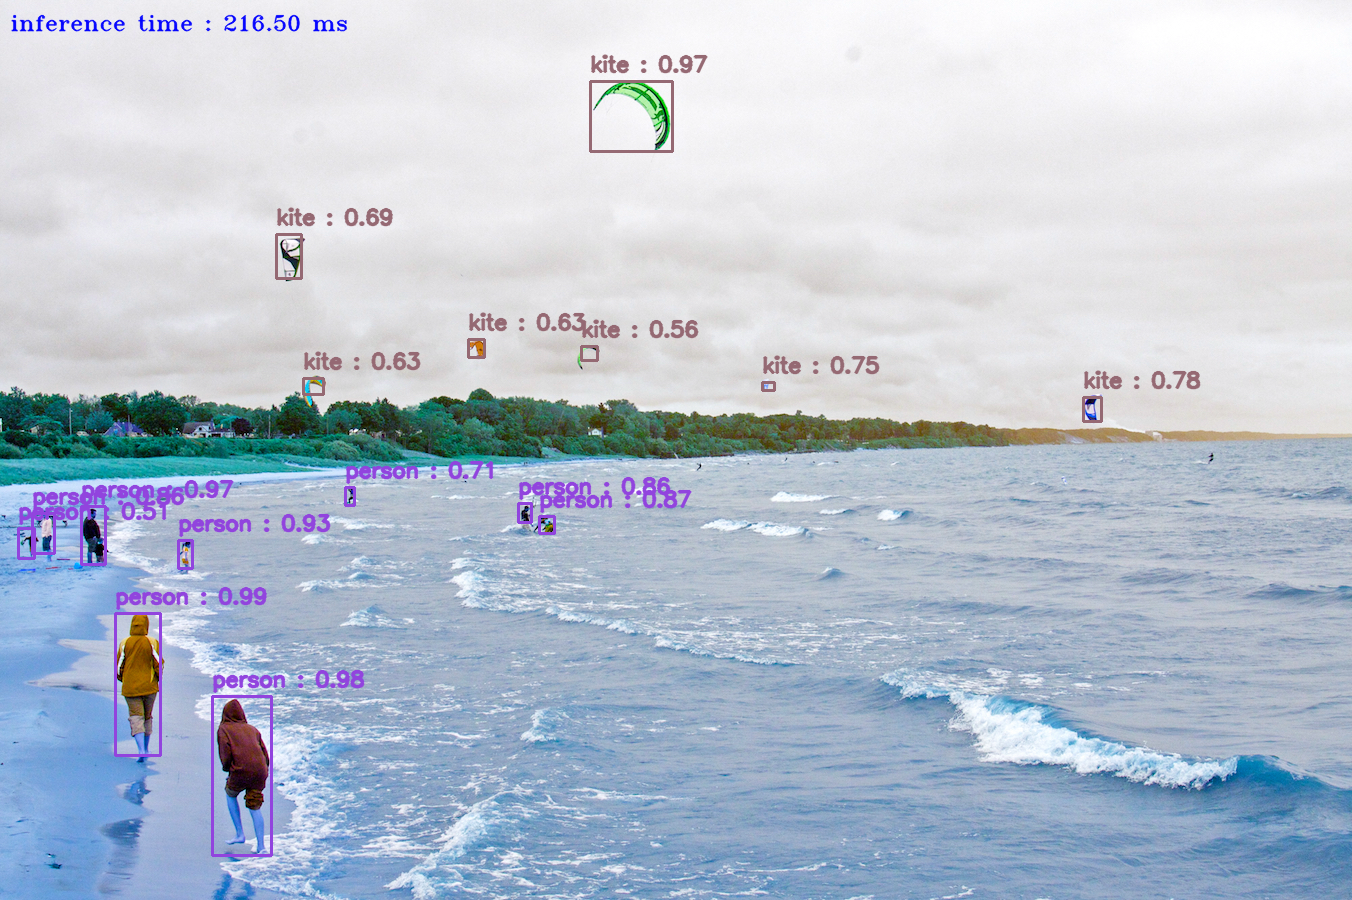

In [121]:
 img_14

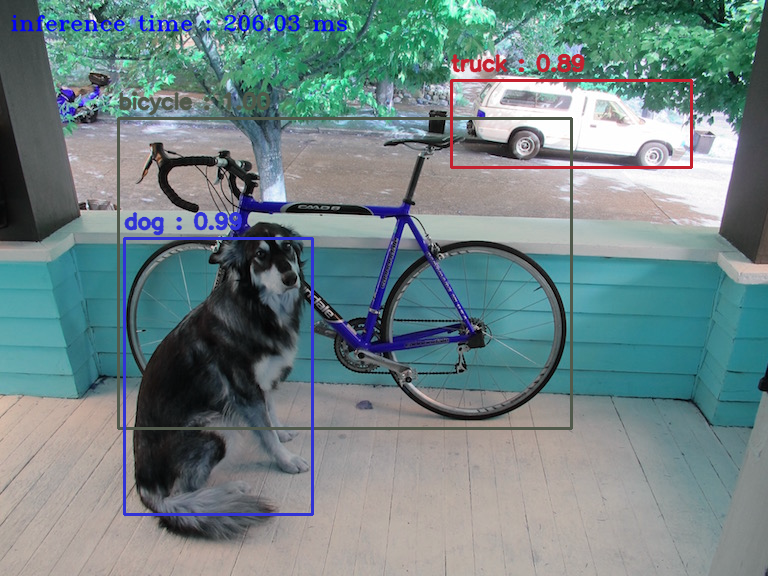

In [122]:
img_7